## Comparative Analysis of RNN, LSTM, and GRU for Financial Forecasting

### 1. Project Overview
This notebook conducts a rigorous comparative analysis of three Recurrent Neural Network architectures—**Simple RNN, LSTM, and GRU**—for the task of directional financial forecasting (Binary Classification: "Up" vs. "Down").

The models are trained on a multivariate dataset comprising 10 years of historical data (2014-2023) for four major technology stocks: **AAPL, META, NFLX, and TSLA**.

**Objective:** To determine if the gating mechanisms in LSTM and GRU architectures provide a tangible benefit over baseline RNNs in mitigating the vanishing gradient problem and capturing long-term dependencies.

In [10]:
# Import core libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import os
from time import time
import matplotlib.pyplot as plt
import seaborn as sns

# Import Scikit-Learn for preprocessing and metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, roc_curve, auc,
    classification_report, precision_score, recall_score
)

# Import TensorFlow/Keras for Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC, Precision, Recall

# Set visualization style
sns.set_style("whitegrid")
print("Libraries imported successfully.")

Libraries imported successfully.


### 2. Data Loading and Unification
We integrate four separate datasets (`AAPL`, `META`, `NFLX`, `TSLA`).
A critical step here is **Target Unification**:
* For datasets with `next_day_close`, we define the target as `1` if the next day's price > current day's price.
* For datasets with a categorical `target` column, we map `'bullish'` to `1`.

This creates a consistent binary target variable `target_label` across all equities.

In [11]:
# Define the source files and their corresponding stock tickers
files_info = {
    'AAPL': 'aapl_2014_2023.csv',
    'META': 'meta_2014_2023.csv',
    'NFLX': 'nflx_2014_2023.csv',
    'TSLA': 'tsla_2014_2023.csv'
}

processed_dfs = []

# Loop through files, load data, and standardize the target
for ticker, filename in files_info.items():
    if os.path.exists(filename):
        df = pd.read_csv(filename)
        df['stock'] = ticker  # Add stock identifier

        # Standardize target definitions
        if 'next_day_close' in df.columns:
            # Logic: Target is 1 if next day's close is higher
            df['target_label'] = (df['next_day_close'] > df['close']).astype(int)
            df = df.drop(columns=['next_day_close'])
        elif 'target' in df.columns:
            # Logic: Target is 1 only if the label is 'bullish'
            df['target_label'] = (df['target'] == 'bullish').astype(int)
            df = df.drop(columns=['target'])
        else:
            print(f"Warning: No target column found for {ticker}")
        
        processed_dfs.append(df)
    else:
        print(f"Error: {filename} not found.")

# Combine into one unified DataFrame
if processed_dfs:
    combined_df = pd.concat(processed_dfs, ignore_index=True)
    combined_df['date'] = pd.to_datetime(combined_df['date'])
    # Sort chronologically to ensure time-series integrity
    combined_df = combined_df.sort_values(by=['date', 'stock']).reset_index(drop=True)
    
    # Save for reference
    combined_df.to_csv('cleaned_multivariate_stocks.csv', index=False)
    print(f"Data unified. Total samples: {combined_df.shape[0]}")

Data unified. Total samples: 10064


### 3. Exploratory Data Analysis (EDA)
Before modeling, we analyze the data properties.
1.  **Adjusted Close Prices:** To visualize the growth trends and volatility differences.
2.  **Daily Returns:** To check for **stationarity**. Neural networks require stationary data (mean ~ 0) to train effectively.
3.  **Correlation:** To see how strongly the assets move together.

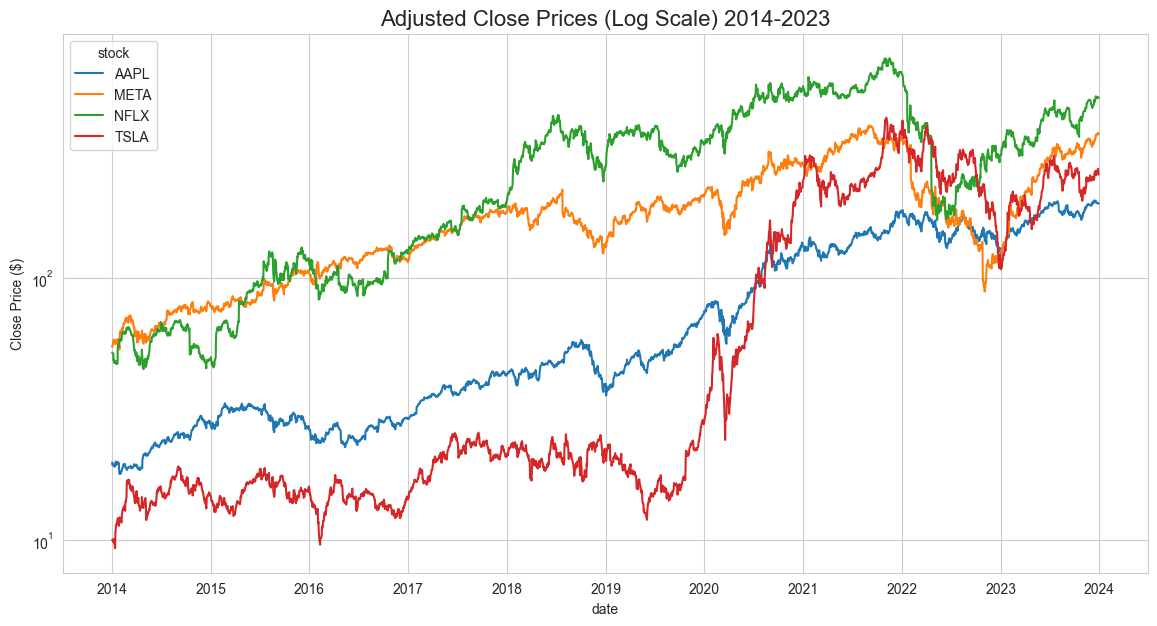

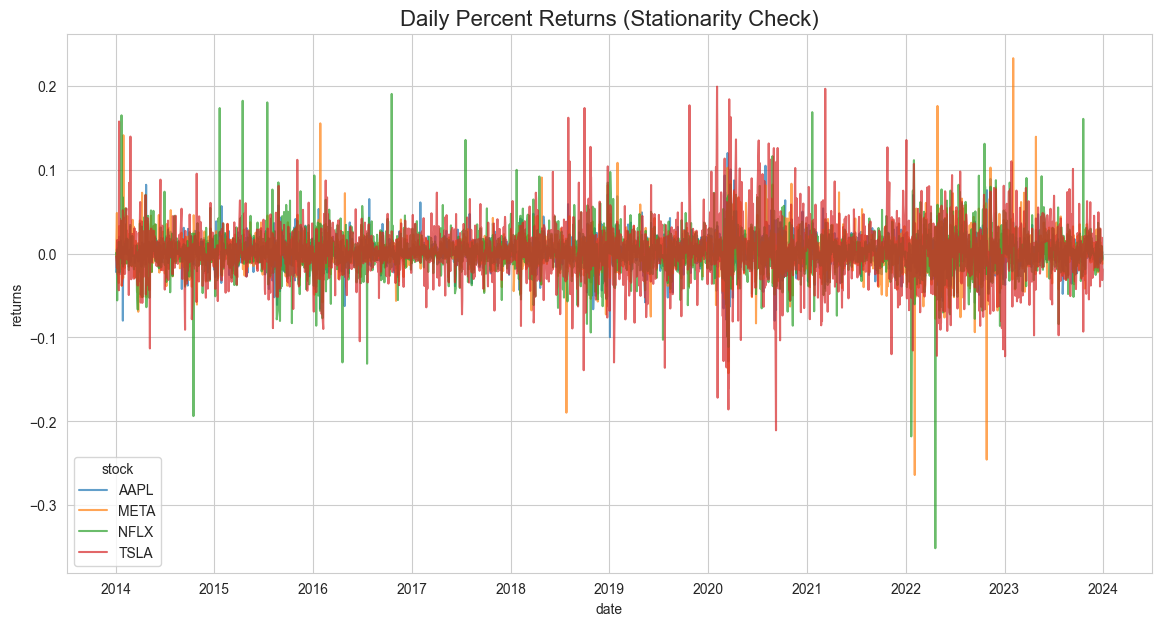

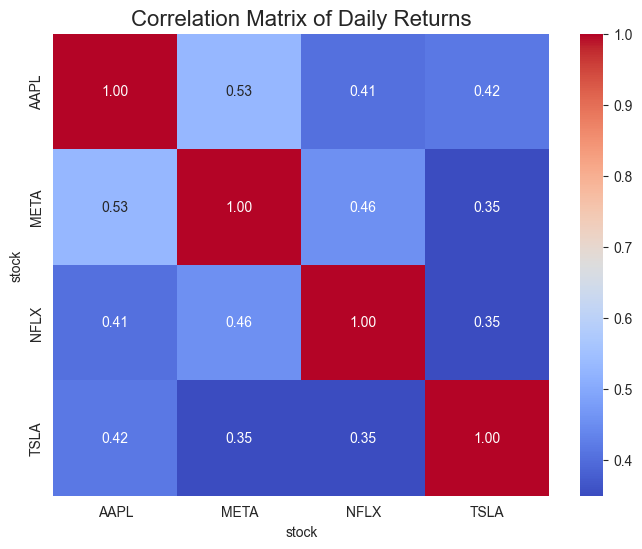

In [12]:
# Reload data for plotting
df = pd.read_csv('cleaned_multivariate_stocks.csv', parse_dates=['date'])

# 1. Price Visualization (Log Scale)
plt.figure(figsize=(14, 7))
sns.lineplot(data=df, x='date', y='close', hue='stock')
plt.yscale('log')
plt.title('Adjusted Close Prices (Log Scale) 2014-2023', fontsize=16)
plt.ylabel('Close Price ($)')
plt.show()

# 2. Stationarity Check (Daily Returns)
df['returns'] = df.groupby('stock')['close'].pct_change()
plt.figure(figsize=(14, 7))
sns.lineplot(data=df, x='date', y='returns', hue='stock', alpha=0.7)
plt.title('Daily Percent Returns (Stationarity Check)', fontsize=16)
plt.show()

# 3. Correlation Matrix
returns_df = df.pivot(index='date', columns='stock', values='returns')
plt.figure(figsize=(8, 6))
sns.heatmap(returns_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Daily Returns', fontsize=16)
plt.show()

### 4. Preprocessing Pipeline
To prepare the data for RNNs, we apply three strict steps:
1.  **Chronological Split:** We split by date (Train: 2014-2021, Val: 2022, Test: 2023) to prevent **lookahead bias**.
2.  **Feature Scaling:** We use `MinMaxScaler` fitted **only** on the training set to simulate a real-world scenario where future data is unknown.
3.  **Sliding Window:** We transform 2D data into 3D sequences (`Samples` x `60 Days` x `18 Features`).

In [13]:
# Set index and define features
df = df.set_index('date')
features = [col for col in df.columns if col not in ['stock', 'target_label', 'returns']]
target_col = 'target_label'

# 1. Chronological Split
train_df = df.loc['2014-01-01':'2021-12-31']
val_df = df.loc['2022-01-01':'2022-12-31']
test_df = df.loc['2023-01-01':'2023-12-31']

# 2. MinMax Scaling (Fit on Train ONLY)
scaler = MinMaxScaler()
scaler.fit(train_df[features])

# Helper function to reconstruct DataFrame after scaling
def create_scaled_df(original_df):
    scaled_data = scaler.transform(original_df[features])
    df_scaled = pd.DataFrame(scaled_data, columns=features, index=original_df.index)
    df_scaled[['stock', target_col]] = original_df[['stock', target_col]]
    return df_scaled

train_scaled_df = create_scaled_df(train_df)
val_scaled_df = create_scaled_df(val_df)
test_scaled_df = create_scaled_df(test_df)

# 3. Sliding Window (Sequence Generation)
SEQUENCE_LENGTH = 60  # Lookback period of 60 days

def create_sequences(data_features, data_target, seq_len):
    X_seq, y_seq = [], []
    for i in range(len(data_features) - seq_len):
        X_seq.append(data_features[i:(i + seq_len)])
        y_seq.append(data_target[i + seq_len])
    return np.array(X_seq), np.array(y_seq)

def process_split(scaled_df, stocks, seq_len):
    X_list, y_list = [], []
    for stock in stocks:
        stock_df = scaled_df[scaled_df['stock'] == stock]
        # Generate sequences per stock to avoid mixing data between Apple and Tesla
        X_stock, y_stock = create_sequences(stock_df[features].values, stock_df[target_col].values, seq_len)
        if X_stock.shape[0] > 0:
            X_list.append(X_stock)
            y_list.append(y_stock)
    return np.concatenate(X_list), np.concatenate(y_list)

# Generate final datasets
stocks = df['stock'].unique()
X_train, y_train = process_split(train_scaled_df, stocks, SEQUENCE_LENGTH)
X_val, y_val = process_split(val_scaled_df, stocks, SEQUENCE_LENGTH)
X_test, y_test = process_split(test_scaled_df, stocks, SEQUENCE_LENGTH)

print(f"Training Shape: {X_train.shape}")
print(f"Testing Shape:  {X_test.shape}")

Training Shape: (7820, 60, 18)
Testing Shape:  (760, 60, 18)


### 5. Model Architecture
We define three models with a consistent architecture to ensure a fair comparison.
* **Simple RNN:** The baseline. Susceptible to vanishing gradients.
* **LSTM:** Uses forget/input/output gates to maintain long-term memory.
* **GRU:** A simplified gated architecture (update/reset gates).

**Shared Hyperparameters:**
* 50 Units (Recurrent Layer)
* 0.2 Dropout (Regularization)
* 25 Units Dense Layer (ReLU)
* 1 Output Unit (Sigmoid)

In [14]:
INPUT_SHAPE = (X_train.shape[1], X_train.shape[2])

def build_simple_rnn(input_shape):
    model = Sequential([
        SimpleRNN(50, activation='tanh', return_sequences=False, input_shape=input_shape),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1, activation='sigmoid')
    ], name="Simple_RNN")
    return model

def build_lstm(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=False, input_shape=input_shape),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1, activation='sigmoid')
    ], name="LSTM")
    return model

def build_gru(input_shape):
    model = Sequential([
        GRU(50, return_sequences=False, input_shape=input_shape),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1, activation='sigmoid')
    ], name="GRU")
    return model

model_builders = {'Simple_RNN': build_simple_rnn, 'LSTM': build_lstm, 'GRU': build_gru}

### 6. Training Loop
We train each model for 100 epochs using the **Adam optimizer** and **Binary Crossentropy** loss.
**Early Stopping** is implemented to halt training if validation loss does not improve for 10 consecutive epochs, preventing overfitting.

In [15]:
BATCH_SIZE = 64
EPOCHS = 100
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_history = {}
model_results = {}
model_predictions = {}

for model_name, build_fn in model_builders.items():
    print(f"\nTraining {model_name}...")
    model = build_fn(INPUT_SHAPE)
    
    # Compile
    model.compile(loss='binary_crossentropy', optimizer='adam', 
                  metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')])
    
    # Train
    start_time = time()
    history = model.fit(
        X_train, y_train,
        batch_size=BATCH_SIZE, epochs=EPOCHS,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping], verbose=1
    )
    train_time = time() - start_time
    model_history[model_name] = pd.DataFrame(history.history)
    
    # Evaluate on Test Set
    test_metrics = model.evaluate(X_test, y_test, verbose=0)
    y_pred_prob = model.predict(X_test).flatten()
    y_pred_class = (y_pred_prob > 0.5).astype(int)
    
    # Store Results
    model_predictions[model_name] = y_pred_prob
    model_results[model_name] = {
        'Loss': test_metrics[0], 
        'Accuracy': test_metrics[1], 
        'AUC': test_metrics[2],
        'Precision': test_metrics[3], 
        'Recall': test_metrics[4],
        'F1-Score': f1_score(y_test, y_pred_class), 
        'Train Time (s)': train_time
    }


Training Simple_RNN...


c:\Users\ryant\OneDrive\Desktop\Post-Graduate\Portfolio\Python\Project - MDS 503\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.5102 - auc: 0.5162 - loss: 0.6945 - precision: 0.4965 - recall: 0.3907 - val_accuracy: 0.4751 - val_auc: 0.5463 - val_loss: 0.6973 - val_precision: 0.4555 - val_recall: 0.8830
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5059 - auc: 0.5094 - loss: 0.6936 - precision: 0.4822 - recall: 0.1956 - val_accuracy: 0.5537 - val_auc: 0.5383 - val_loss: 0.6914 - val_precision: 0.5172 - val_recall: 0.0439
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5207 - auc: 0.5287 - loss: 0.6921 - precision: 0.5145 - recall: 0.2846 - val_accuracy: 0.5471 - val_auc: 0.5384 - val_loss: 0.6913 - val_precision: 0.4935 - val_recall: 0.4474
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5235 - auc: 0.5268 - loss: 0.6923 - precision: 0.5184 - recall: 0.3072 - val_accuracy: 0.4725 - val_auc: 0.5190 - val_loss: 0.6945 - val_precision: 0.4559 - val_recall: 0.9211
Epoch 5/100
123/123 ━━━━

c:\Users\ryant\OneDrive\Desktop\Post-Graduate\Portfolio\Python\Project - MDS 503\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


123/123 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.5260 - auc: 0.5249 - loss: 0.6924 - precision: 0.5170 - recall: 0.4075 - val_accuracy: 0.5524 - val_auc: 0.5363 - val_loss: 0.6916 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.5233 - auc: 0.5336 - loss: 0.6913 - precision: 0.5180 - recall: 0.3061 - val_accuracy: 0.4476 - val_auc: 0.5416 - val_loss: 0.6975 - val_precision: 0.4476 - val_recall: 1.0000
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.5285 - auc: 0.5361 - loss: 0.6907 - precision: 0.5173 - recall: 0.4802 - val_accuracy: 0.4529 - val_auc: 0.5432 - val_loss: 0.6962 - val_precision: 0.4499 - val_recall: 0.9971
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.5265 - auc: 0.5412 - loss: 0.6904 - precision: 0.5175 - recall: 0.4103 - val_accuracy: 0.4476 - val_auc: 0.5312 - val_loss: 0.7008 - val_precision: 0.4476 - val_recall: 1.0000
Epoch 5/100
123/123 ━━━━━━━━

c:\Users\ryant\OneDrive\Desktop\Post-Graduate\Portfolio\Python\Project - MDS 503\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


123/123 ━━━━━━━━━━━━━━━━━━━━ 15s 68ms/step - accuracy: 0.5240 - auc: 0.5242 - loss: 0.6930 - precision: 0.5180 - recall: 0.3295 - val_accuracy: 0.5471 - val_auc: 0.5250 - val_loss: 0.6894 - val_precision: 0.4615 - val_recall: 0.0702
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.5267 - auc: 0.5298 - loss: 0.6919 - precision: 0.5263 - recall: 0.2838 - val_accuracy: 0.4647 - val_auc: 0.5365 - val_loss: 0.6958 - val_precision: 0.4518 - val_recall: 0.9181
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.5294 - auc: 0.5308 - loss: 0.6916 - precision: 0.5232 - recall: 0.3812 - val_accuracy: 0.5458 - val_auc: 0.5474 - val_loss: 0.6872 - val_precision: 0.4757 - val_recall: 0.1433
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.5306 - auc: 0.5365 - loss: 0.6912 - precision: 0.5240 - recall: 0.3962 - val_accuracy: 0.5092 - val_auc: 0.5451 - val_loss: 0.6925 - val_precision: 0.4697 - val_recall: 0.7485
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━

### 7. Benchmarking & Results
We compare the Deep Learning models against a **Dummy Classifier** (which always predicts the majority class) to establish a baseline.

**Key Visualizations:**
1.  **ROC Curve:** Compares the discriminative ability (AUC) of the models.
2.  **Loss History:** Visualizes the "Vanishing Gradient" problem (Simple RNN loss flatlining).

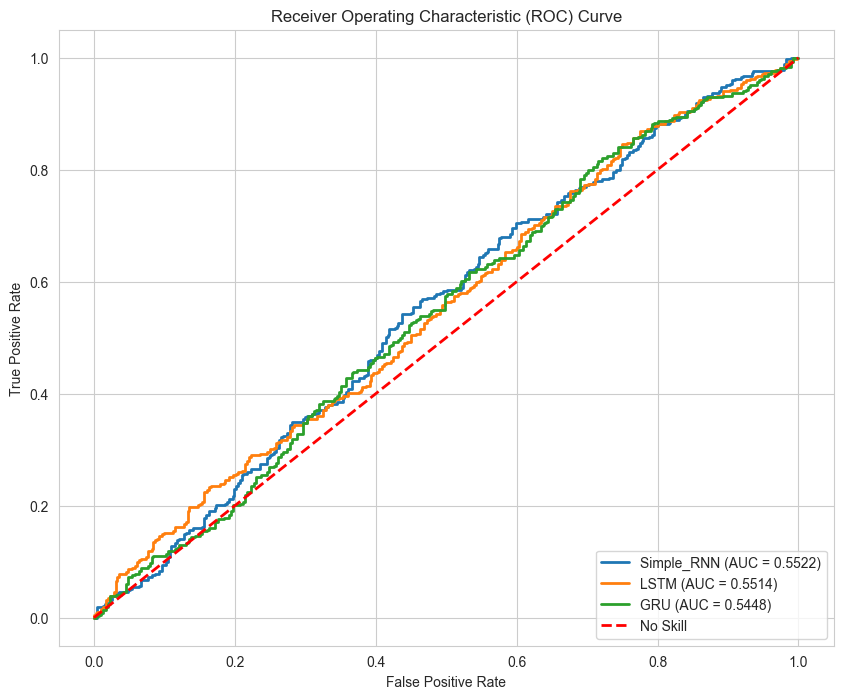

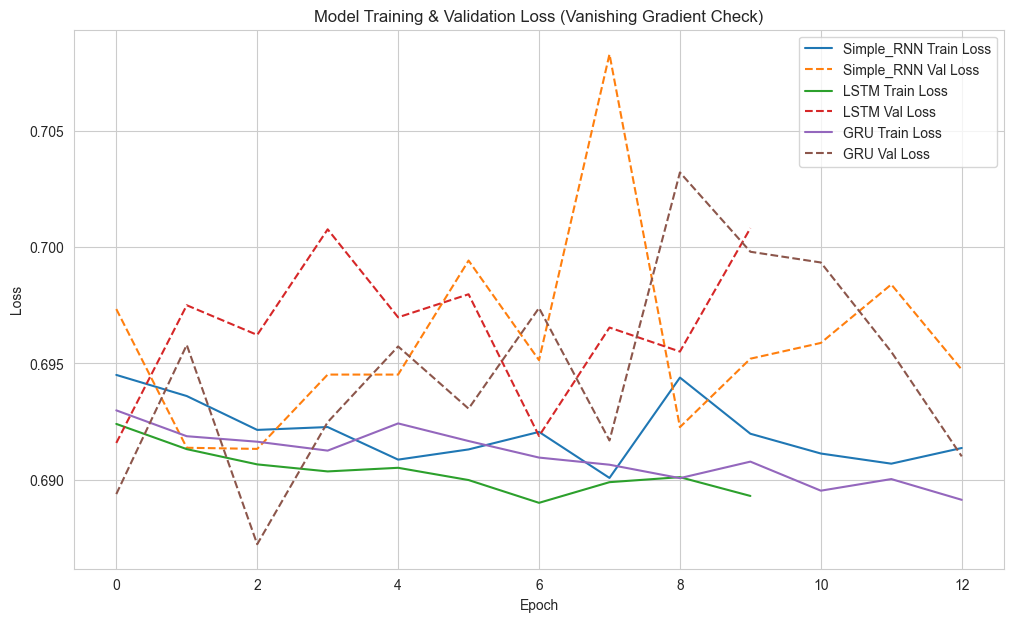

,Loss,Accuracy,AUC,Precision,Recall,F1-Score,Train Time (s)
Simple_RNN,0.691114,0.517105,0.550063,0.506667,0.205962,0.292871,32.993576
LSTM,0.691902,0.514474,0.545939,0.000000,0.000000,0.000000,61.694601
GRU,0.690559,0.522368,0.544535,0.550000,0.089431,0.153846,89.717788
Dummy,NaN,0.514474,0.500000,0.000000,0.000000,0.000000,0.000000


In [16]:
# 1. Dummy Classifier Benchmark
dummy_model = DummyClassifier(strategy='most_frequent')
dummy_model.fit(y_train, y_train)
y_prob_dummy = dummy_model.predict_proba(X_test)[:, 1]
fpr_dummy, tpr_dummy, _ = roc_curve(y_test, y_prob_dummy)

model_results['Dummy'] = {
    'AUC': auc(fpr_dummy, tpr_dummy),
    'Accuracy': accuracy_score(y_test, dummy_model.predict(X_test)),
    'Precision': 0, 'Recall': 0, 'F1-Score': 0, 'Train Time (s)': 0
}

# 2. Plot ROC Curves
plt.figure(figsize=(10, 8))
for model_name, y_prob in model_predictions.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})', lw=2)

plt.plot([0, 1], [0, 1], 'r--', label='No Skill', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# 3. Plot Training Loss History
plt.figure(figsize=(12, 7))
for model_name, history_df in model_history.items():
    plt.plot(history_df['loss'], label=f'{model_name} Train Loss')
    plt.plot(history_df['val_loss'], label=f'{model_name} Val Loss', linestyle='--')

plt.title('Model Training & Validation Loss (Vanishing Gradient Check)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 4. Display Final Results Table
results_df = pd.DataFrame.from_dict(model_results, orient='index').sort_values(by='AUC', ascending=False)
display(results_df)